<a id="1"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Libraires And Utilities</h1>

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
pyo.init_notebook_mode()
from imblearn.over_sampling import SMOTE
import scikitplot as skplt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score


from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import os

from sklearn.metrics import classification_report,confusion_matrix,f1_score
import warnings
warnings.filterwarnings('ignore')

plt.rc('figure',figsize=(17,13))
sns.set_context('paper',font_scale=2)

def set_seed(seed=31415):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

ModuleNotFoundError: No module named 'scikitplot'

In [29]:
s_data = pd.read_csv('/Users/jaikumar/Desktop/Berkeley_ML/DataSets_starter/stroke/healthcare-dataset-stroke-data.csv')
s_data.head(3)
#s_data.info()


id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   

   stroke  
0       1  
1       1  
2       1

<a id="1"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Data Preprocessing</h1>


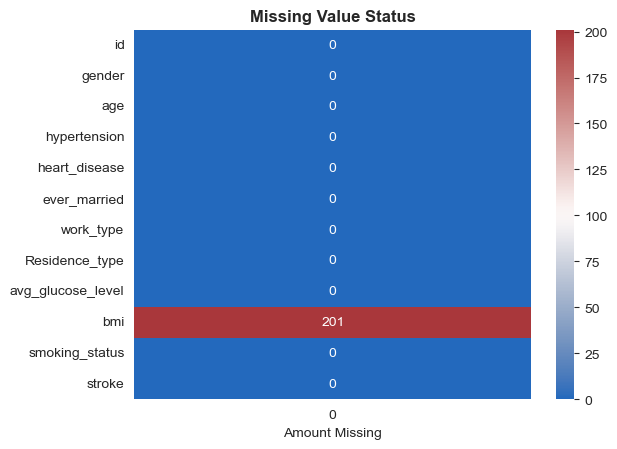

In [19]:
plt.title('Missing Value Status',fontweight='bold')
ax = sns.heatmap(s_data.isna().sum().to_frame(),annot=True,fmt='d',cmap='vlag')
#ax = sns.heatmap(s_data.isna().sum().to_frame(),annot=True)

ax.set_xlabel('Amount Missing')
plt.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>Initially, the dataset had 201 samples with absent BMI value; rather than imputing it naively with the mean or the median, we used a simple decision tree model which based on the age and gender of all other samples gave us a fair prediction for the missing values.</span></p>
<p><br></p>

<a id="1"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Exploratory Data Analysis</h1>


<a id="1"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Analysis of Entire Sample Space</h1>


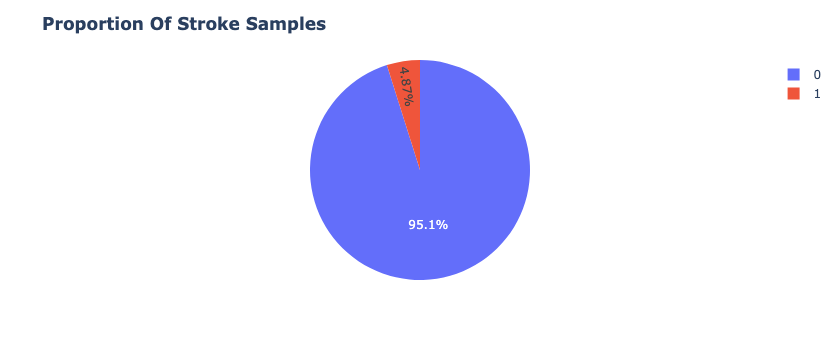

In [5]:
fig = ex.pie(s_data,names='stroke')
fig.update_layout(title='<b>Proportion Of Stroke Samples<b>')
fig.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>We are clearly dealing with an imbalanced dataset, and later in our pipeline, we will have to deal with this problem potentially with upscaling; that way, we give our models a better chance of learning the small details which define potential stroke individuals.</span></p>
<p><br></p>

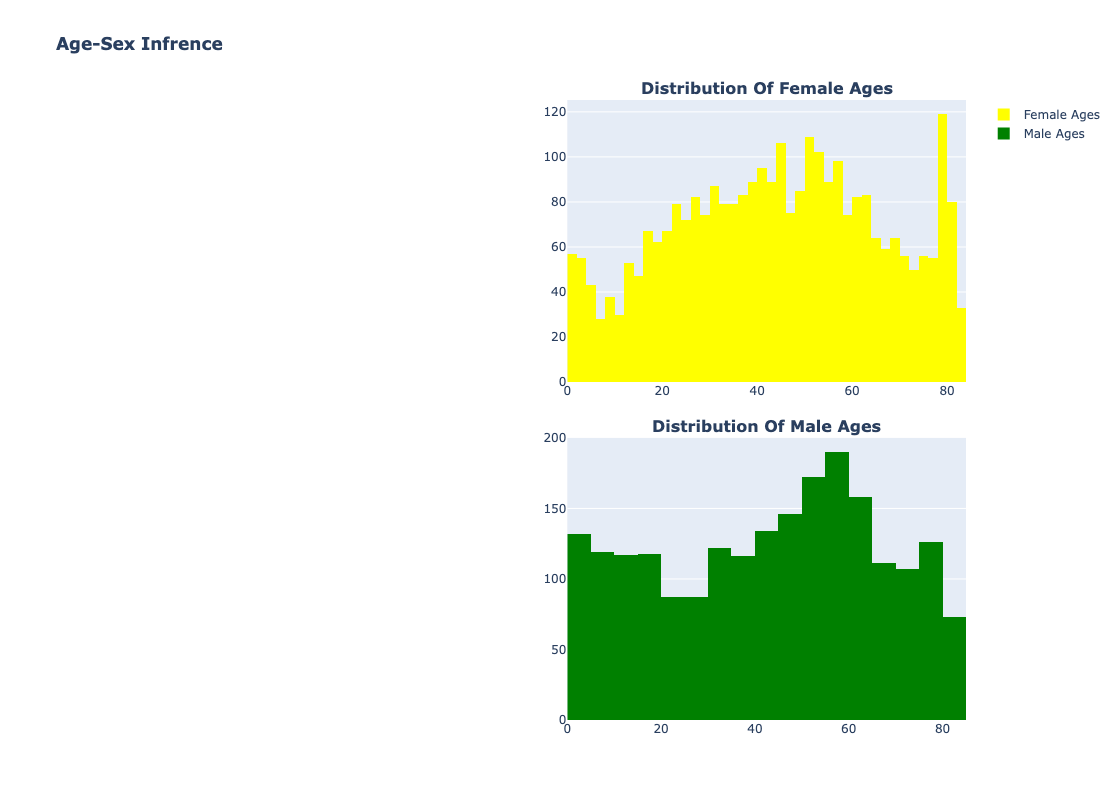

In [21]:
fig = make_subplots(
    rows=2, cols=2,subplot_titles=('','<b>Distribution Of Female Ages<b>','<b>Distribution Of Male Ages<b>','Residuals'),
    vertical_spacing=0.09,
    specs=[[{"type": "pie","rowspan": 2}       ,{"type": "histogram"}] ,
           [None                               ,{"type": "histogram"}]            ,                                      
          ]
)

#fig.add_trace(
#    go.Pie(values=s_data.gender.value_counts().values,labels=['<b>Female<b>','<b>Male<b>','<b>Other<b>'],hole=0.3,pull=[0,0.08,0.3],marker_colors=['pink','lightblue','green'],textposition='inside'),
#    row=1, col=1
#)

fig.add_trace(
    go.Histogram(
        x=s_data.query('gender=="Female"').age,marker= dict(color='yellow'),name='Female Ages'
    ),
    row=1, col=2
)


fig.add_trace(
    go.Histogram(
        x=s_data.query('gender=="Male"').age,marker= dict(color='green'),name='Male Ages'
    ),
    row=2, col=2
)


fig.update_layout(
    height=800,
    showlegend=True,
    title_text="<b>Age-Sex Infrence<b>",
)

fig.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>There are slightly more females in our sample data than males and from a visual perspective, the ages seem to be normally distributed but with a high variance measure due to the visible fat tail.</span></p>

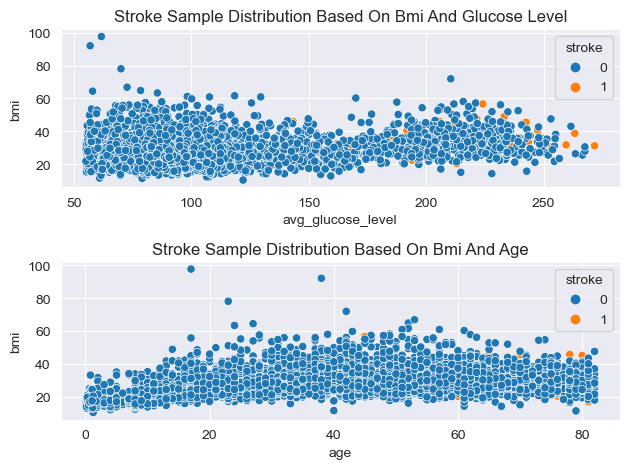

In [7]:
plt.subplot(2,1,1)
plt.title('Stroke Sample Distribution Based On Bmi And Glucose Level')
sns.scatterplot(x=s_data['avg_glucose_level'],y=s_data['bmi'],hue=s_data['stroke'])
plt.subplot(2,1,2)
plt.title('Stroke Sample Distribution Based On Bmi And Age')
sns.scatterplot(x=s_data['age'],y=s_data['bmi'],hue=s_data['stroke'])
plt.tight_layout()
plt.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>It seems that we have two underlying populations based on the first scatter plot where the x-axis is the glucose level.<br>What it visible straight away is the fact the in both scatterplots the individuals who had a stroke are located in the BMI value region under 60 and in high glucose levels as well as old age. </span></p>

<a id="1"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Analysis of Stroke Positve Population</h1>


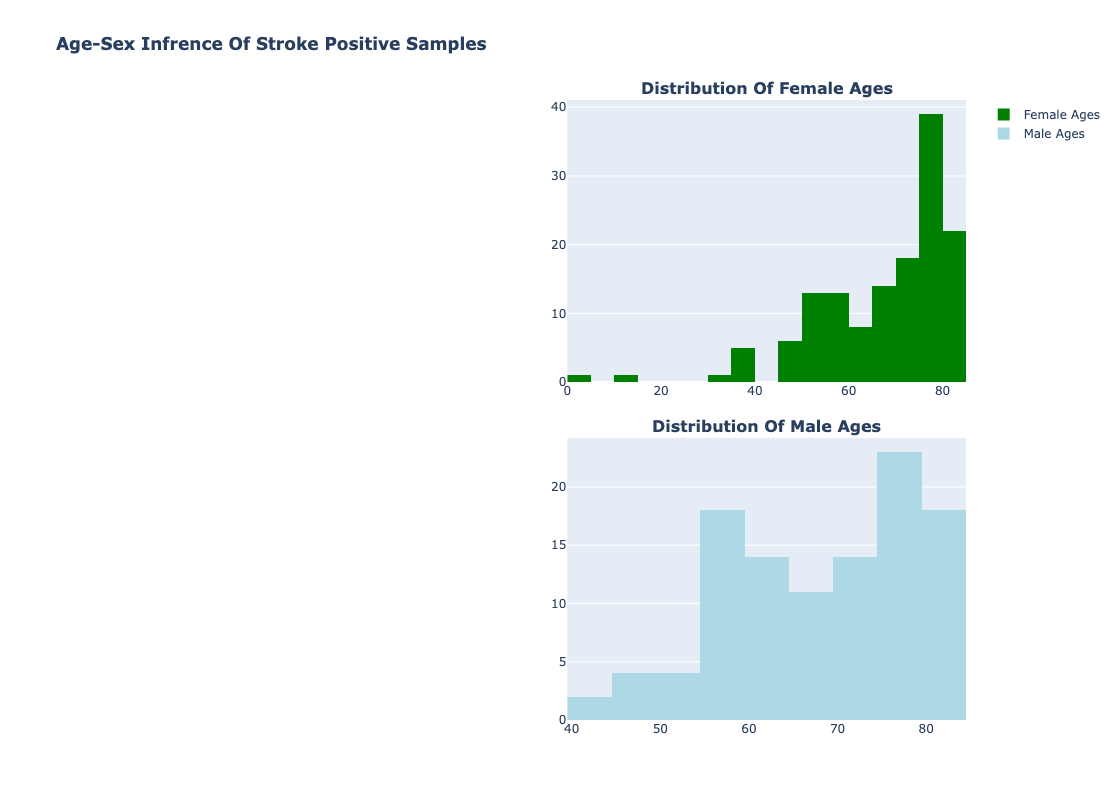

In [30]:
stroke_population = s_data.query('stroke ==1').copy()

fig = make_subplots(
    rows=2, cols=2,subplot_titles=('','<b>Distribution Of Female Ages<b>','<b>Distribution Of Male Ages<b>','Residuals'),
    vertical_spacing=0.09,
    specs=[[{"type": "pie","rowspan": 2}       ,{"type": "histogram"}] ,
           [None                               ,{"type": "histogram"}]            ,                                      
          ]
)

#fig.add_trace(
#    go.Pie(values=stroke_population.gender.value_counts().values,labels=['<b>Female<b>','<b>Male<b>','<b>Other<b>'],hole=0.3,pull=[0,0.08,0.3],marker_colors=['pink','lightblue','green'],textposition='inside'),
#    row=1, col=1
#)

fig.add_trace(
    go.Histogram(
        x=stroke_population.query('gender=="Female"').age,marker= dict(color='green'),name='Female Ages'
    ),
    row=1, col=2
)


fig.add_trace(
    go.Histogram(
        x=stroke_population.query('gender=="Male"').age,marker= dict(color='lightblue'),name='Male Ages'
    ),
    row=2, col=2
)



fig.update_layout(
    height=800,
    showlegend=True,
    title_text="<b>Age-Sex Infrence Of Stroke Positive Samples<b>",
)

fig.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>When looking at the inner distribution of our different attributes among stroke positive samples, we see a couple of interesting points to be noted; the first is that females, although appearing more than males in our dataset, also surpass the males in the stroke sample space, the second point to be noted is that males are more prone to strokes in their early 50/60 where the median of the women stroke age is around 75-79.</span></p>

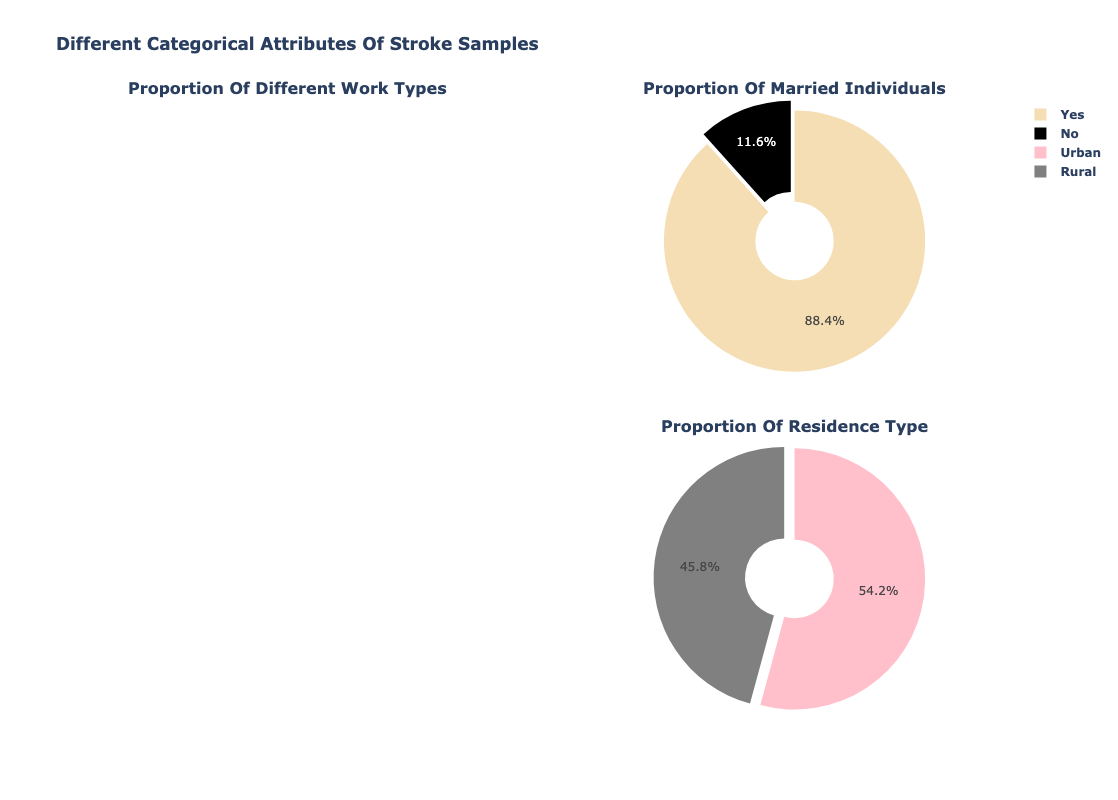

In [23]:
stroke_population = s_data.query('stroke ==1').copy()

fig = make_subplots(
    rows=2, cols=2,subplot_titles=('<b>Proportion Of Different Work Types<b>','<b>Proportion Of Married Individuals<b>','<b>Proportion Of Residence Type<b>','Residuals'),
    vertical_spacing=0.09,
    specs=[[{"type": "pie","rowspan": 2}       ,{"type": "pie"}] ,
           [None                               ,{"type": "pie"}]            ,                                      
          ]
)

#fig.add_trace(
#    go.Pie(values=stroke_population.work_type.value_counts().values,labels=['<b>Private<b>','<b>Self-employed<b>','<b>Govt_job<b>','<b>children<b>','<b>Never_worked<b>'],hole=0.3,pull=[0,0.08,0.03,0.2],marker_colors=['orange','green','blue','brown','purple'],textposition='inside'),
#    row=1, col=1
#)

fig.add_trace(
    go.Pie(values=stroke_population.ever_married.value_counts().values,labels=['<b>Yes<b>','<b>No<b>'],hole=0.3,pull=[0,0.08],marker_colors=['wheat','black'],textposition='inside'),
    row=1, col=2
)
fig.add_trace(
    go.Pie(values=stroke_population.Residence_type.value_counts().values,labels=['<b>Urban<b>','<b>Rural<b>'],hole=0.3,pull=[0,0.08],marker_colors=['pink','gray'],textposition='inside'),
    row=2, col=2
)

fig.update_layout(
    height=800,
    showlegend=True,
    title_text="<b>Different Categorical Attributes Of Stroke Samples<b>",
)

fig.show()

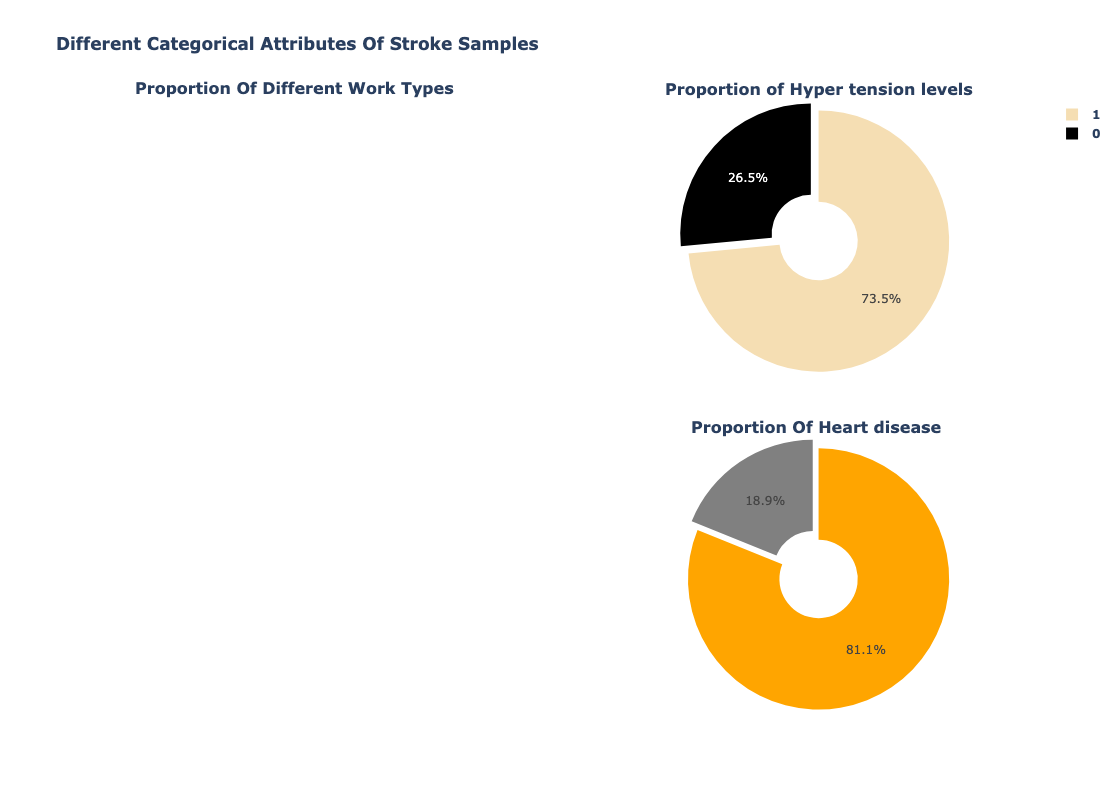

In [35]:
stroke_population = s_data.query('stroke ==1').copy()

fig = make_subplots(
    rows=2, cols=2,subplot_titles=('<b>Proportion Of Different Work Types<b>','<b>Proportion of Hyper tension levels<b>','<b>Proportion Of Heart disease <b>','Residuals'),
    vertical_spacing=0.09,
    specs=[[{"type": "pie","rowspan": 2}       ,{"type": "pie"}] ,
           [None                               ,{"type": "pie"}]            ,                                      
          ]
)

#fig.add_trace(
#    go.Pie(values=stroke_population.work_type.value_counts().values,labels=['<b>Private<b>','<b>Self-employed<b>','<b>Govt_job<b>','<b>children<b>','<b>Never_worked<b>'],hole=0.3,pull=[0,0.08,0.03,0.2],marker_colors=['orange','green','blue','brown','purple'],textposition='inside'),
#    row=1, col=1
#)

fig.add_trace(
    go.Pie(values=stroke_population.hypertension.value_counts().values,labels=['<b>1<b>','<b>0<b>'],hole=0.3,pull=[0,0.08],marker_colors=['wheat','black'],textposition='inside'),
    row=1, col=2
)
fig.add_trace(
    go.Pie(values=stroke_population.heart_disease.value_counts().values,labels=['<b>1<b>','<b>0<b>'],hole=0.3,pull=[0,0.08],marker_colors=['orange','gray'],textposition='inside'),
    row=2, col=2
)

fig.update_layout(
    height=800,
    showlegend=True,
    title_text="<b>Different Categorical Attributes Of Stroke Samples<b>",
)

fig.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>It seems that the marriage status and the residence type are distributed in a way that doesn&apos;t tell us anything confounding about stroke-positive individuals, the residence type is close to a uniform distribution and the marriage status is almost completely dominated by one of the values.</span></p>

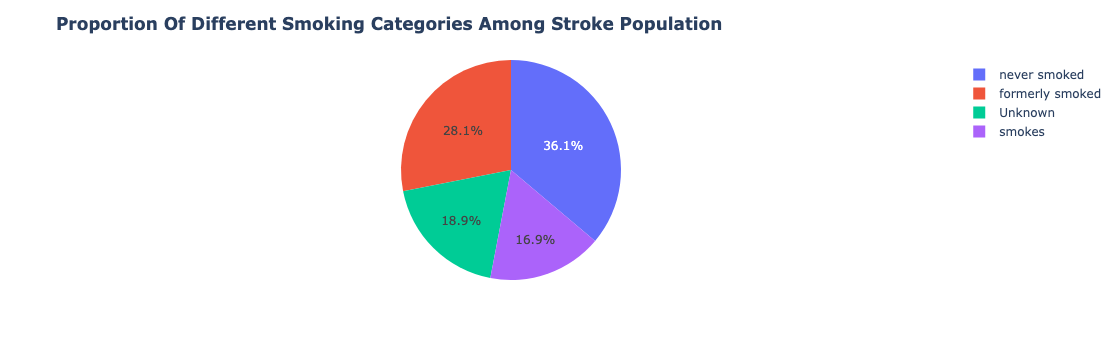

In [24]:
fig = ex.pie(stroke_population,names='smoking_status')
fig.update_layout(title='<b>Proportion Of Different Smoking Categories Among Stroke Population<b>')
fig.show()

In [36]:
s_data.gender = s_data.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
s_data.Residence_type = s_data.Residence_type.replace({'Rural':0,'Urban':1}).astype(np.uint8)
s_data.work_type = s_data.work_type.replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)


In [37]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Perason Correaltion',  'Spearman Correaltion'))
colorscale=     [[1.0              , "rgb(165,0,38)"],
                [0.8888888888888888, "rgb(215,48,39)"],
                [0.7777777777777778, "rgb(244,109,67)"],
                [0.6666666666666666, "rgb(253,174,97)"],
                [0.5555555555555556, "rgb(254,224,144)"],
                [0.4444444444444444, "rgb(224,243,248)"],
                [0.3333333333333333, "rgb(171,217,233)"],
                [0.2222222222222222, "rgb(116,173,209)"],
                [0.1111111111111111, "rgb(69,117,180)"],
                [0.0               , "rgb(49,54,149)"]]

s_val =s_data.corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',showscale=False,xgap=1,ygap=1,colorscale=colorscale),
    row=1, col=1
)


s_val =s_data.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,xgap=1,ygap=1,colorscale=colorscale),
    row=2, col=1
)

fig.update_layout(height=700, width=900, title_text="Locations That Contribute The Most To Our Cut-Offs")
fig.show()

ValueError: could not convert string to float: 'Yes'

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>As for numeric correlation, it seems that there is no clear numeric correlation between the stroke attribute and other numeric attributes in our dataset.</span></p>

<a id="1"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Probabilistic Infrence</h1>


In [13]:
import pymc3 as pm
import theano.tensor as tt
with pm.Model():
    p_s = pm.Uniform('p_stroke',0,1)
    
    
    stroke = pm.Bernoulli('pstroke',p_s,observed=s_data.stroke)
    
    
    step = pm.Metropolis()
    trace = pm.sample(50000,step=step)
    burned_trace = trace[40000:]

ModuleNotFoundError: No module named 'pymc3'

In [14]:
beta_samples = burned_trace['p_stroke']

plt.subplot(211)
plt.title(r"Posterior distributions of the Probability Of A Stroke After Observing Our Data")
_hist = plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $P_{Stroke}$", color="#7A68A6")
plt.vlines(beta_samples.mean(),0,1.1*np.max(_hist[0]),label='Posterior Mean',linestyle='-.',linewidth=3,color='red')
plt.vlines(beta_samples.mean()-2*beta_samples.std(),0,1.1*np.max(_hist[0]),label='95% Confidence Bound',linestyle='-.',linewidth=3,color='tab:green')
plt.vlines(beta_samples.mean()+2*beta_samples.std(),0,1.1*np.max(_hist[0]),linestyle='-.',linewidth=3,color='tab:green')

plt.legend()
plt.show()


NameError: name 'burned_trace' is not defined

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>Next, we will make the following assumptions: The age of the population prone to strokes is normally distributed, meaning we can model that distribution of stroke-prone individuals using a Normal distribution with some unknown mu and sigma.</span></p>
<p style="text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;">The same logic is applied to the population of those who are less prone to strokes; we will refer to them as the &quot;resistant&quot; population.</span></span></p>
<p style="text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;">Our goal in the following cells will be to model these Normal distributions, which we will denote by $$N_{prone} \sim (\mu_{prone},\sigma_{prone})$$,$$N_{resistant} \sim (\mu_{resistant},\sigma_{resistant})$$.</span></span></p>
<p style="text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;">We will create a prior landscape where all the possible parameters for our Normal distribution may reside and produce a posterior landscape using the observed data we have; of course, the probability of belonging to the stroke-prone population, as we saw in the figure above, is between 0.04 and 0.06 with 99% confidence interval.</span></span></p>
<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>We will use Monte Carlo Markov Chain to traverse our posterior landscape and gather samples from it which we will examine to decide what parameters suffices are Normal models and how confident we are in them.</span></p>
<p><br></p>

In [15]:
with pm.Model() as t:
    p_s = pm.Uniform('p_stroke',0.04,0.06)
    p_ns = 1-p_s
    p = tt.stack([p_s,p_ns])
    assigment = pm.Categorical('assigment',p,shape=s_data.shape[0],testval=np.random.randint(0,1,s_data.shape[0]))
    
    sd = pm.Uniform('sd',0,100,shape=2)
    center = pm.Normal('center',mu=np.array([40,20]),sd=np.array([30,30]),shape=2)
    
    center_i= pm.Deterministic('center_i',center[assigment])
    sd_i= pm.Deterministic('sd_i',sd[assigment])
    
    observation = pm.Normal('obs',mu=center_i,sd=sd_i,observed=s_data.age)
    
    
    step = pm.Metropolis(vars=[p,sd,center])
    step_c = pm.ElemwiseCategorical(vars=[assigment])
    trace = pm.sample(6000,step=[step,step_c])

In [25]:
center_trace = trace['center'][8000:]
std_trace = trace["sd"][8000:]
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

_i = [1, 2, 3, 4]
titles = ["Posterior of Stroke Prone Ages $\mu$","Posterior of Stroke Prone Ages $\sigma$","Posterior of Stroke Resistant Ages $\mu$","Posterior of Stroke Resistant Ages $\sigma$"]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title(titles[2 * i])
    plt.hist(center_trace[:, i], color=colors[i], bins=10,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title(titles[2 * i + 1])
    plt.hist(std_trace[:, i], color=colors[i], bins=25,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

NameError: name 'trace' is not defined

<a id="1"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Upsampling The Dataset</h1>


In [17]:
oversample = SMOTE()
eval_df = s_data[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi','stroke']].sample(int(s_data.shape[0]*0.2),random_state=42)
train_df = s_data.drop(index=eval_df.index)

X_eval,y_eval = eval_df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']], eval_df['stroke']
X,y = train_df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']], train_df['stroke']


X, y = oversample.fit_resample(X,y)
usampled_df = X.assign(Stroke = y)

X_eval,y_eval = oversample.fit_resample(X_eval,y_eval)
usampled_eval_df = X_eval.assign(Stroke = y_eval)

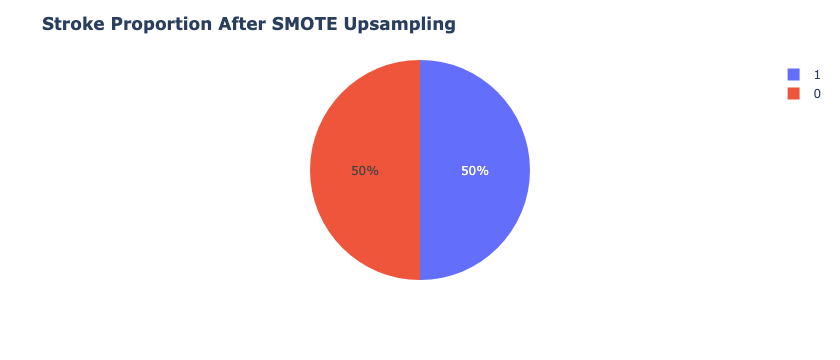

In [18]:
fig = ex.pie(usampled_df,names='Stroke')
fig.update_layout(title='<b>Stroke Proportion After SMOTE Upsampling<b>')
fig.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>Now that we have an upsampled version of our dataset where both sample outcomes are uniformly distributed, the models we will try to train will have a better chance of picking up on the details that define stroke individuals from those who are negative for a stroke.</span></p>
<p><br></p>

<a id="1"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Model Selection</h1>


In [19]:
DT_PIPE = Pipeline(steps = [('scale',StandardScaler()),('DT',DecisionTreeClassifier(random_state=42))])
RF_PIPE = Pipeline(steps = [('scale',StandardScaler()),('DT',RandomForestClassifier(random_state=42))])
SVM_PIPE = Pipeline(steps = [('scale',StandardScaler()),('DT',SVC(random_state=42))])
LR_PIPE = Pipeline(steps = [('scale',StandardScaler()),('DT',LogisticRegression(random_state=42))])

X = usampled_df.iloc[:,:-1]
Y = usampled_df.iloc[:,-1]

X_EVAL = usampled_eval_df.iloc[:,:-1]
Y_EVAL = usampled_eval_df.iloc[:,-1]

holdout_x = X.sample(100)
holdout_y = Y.loc[X.index]

X = X.drop(index=holdout_x.index)
Y = Y.drop(index=holdout_x.index)

<a id="1"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Model Evaluation</h1>


In [20]:
DT_CROSS_VAL = cross_val_score(DT_PIPE,X,Y,cv=10,scoring='f1')
RF_CROSS_VAL = cross_val_score(RF_PIPE,X,Y,cv=10,scoring='f1')
SVM_CROSS_VAL = cross_val_score(SVM_PIPE,X,Y,cv=10,scoring='f1')
LR_CROSS_VAL = cross_val_score(LR_PIPE,X,Y,cv=10,scoring='f1')

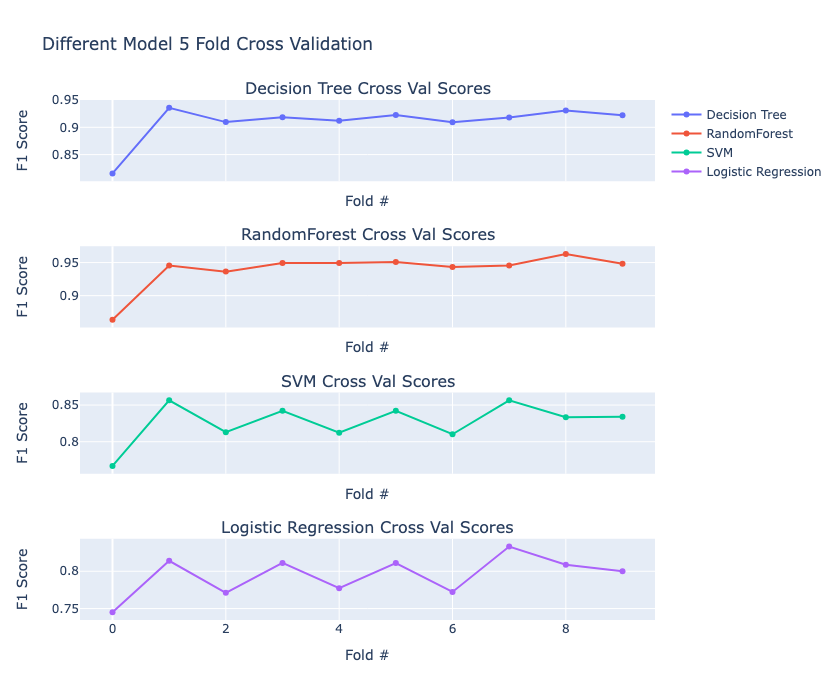

In [21]:
fig = make_subplots(rows=4, cols=1,shared_xaxes=True,subplot_titles=('Decision Tree Cross Val Scores',
                                                                     'RandomForest Cross Val Scores',
                                                                    'SVM Cross Val Scores','Logistic Regression Cross Val Scores'))

fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=DT_CROSS_VAL,name='Decision Tree'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=RF_CROSS_VAL,name='RandomForest'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=SVM_CROSS_VAL,name='SVM'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=LR_CROSS_VAL,name='Logistic Regression'),
    row=4, col=1
)

fig.update_layout(height=700, width=900, title_text="Different Model 5 Fold Cross Validation")
fig.update_yaxes(title_text="F1 Score")
fig.update_xaxes(title_text="Fold #")

fig.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>It seems from our cross-validation test that the random forest and decision tree models did the best on the average of overfitting the sample data, to test that those models indeed learned to predict stroke-prone individuals we will test those models once again on the original data before we performed upsampling.</span></p>

<a id="1"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Model Evaluation On Original Data (Before Upsampling)</h1>


In [22]:
DT_PIPE.fit(X,Y)
RF_PIPE.fit(X,Y)
SVM_PIPE.fit(X,Y)
LR_PIPE.fit(X,Y)

X = s_data.loc[:,X.columns]
Y = s_data.loc[:,'stroke']

DT_PRED   = DT_PIPE.predict(X_EVAL)
RF_PRED   =RF_PIPE.predict(X_EVAL)
SVM_PRED  = SVM_PIPE.predict(X_EVAL)
LR_PRED   = LR_PIPE.predict(X_EVAL)

DT_CM  = confusion_matrix(Y_EVAL,DT_PRED )
RF_CM  = confusion_matrix(Y_EVAL,RF_PRED )
SVM_CM = confusion_matrix(Y_EVAL,SVM_PRED)
LR_CM  = confusion_matrix(Y_EVAL,LR_PRED )

DT_F1  = f1_score(Y_EVAL,DT_PRED )
RF_F1  = f1_score(Y_EVAL,RF_PRED )
SVM_F1 = f1_score(Y_EVAL,SVM_PRED)
LR_F1  = f1_score(Y_EVAL,LR_PRED )

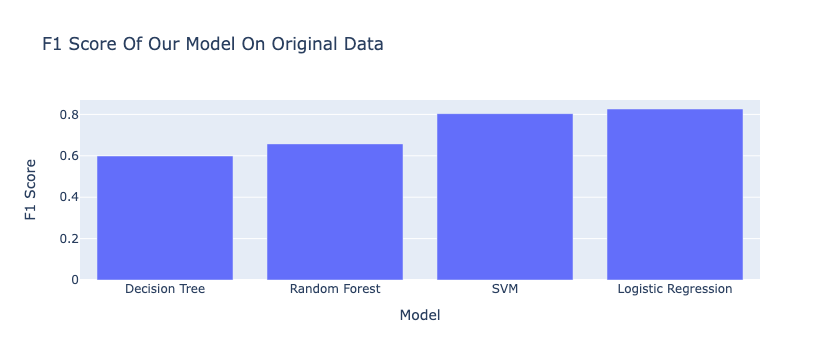

In [23]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['Decision Tree','Random Forest','SVM','Logistic Regression'],y=[DT_F1,RF_F1,SVM_F1,LR_F1]))
fig.update_layout(title='F1 Score Of Our Model On Original Data',xaxis_title='Model',yaxis_title='F1 Score')
fig.show()

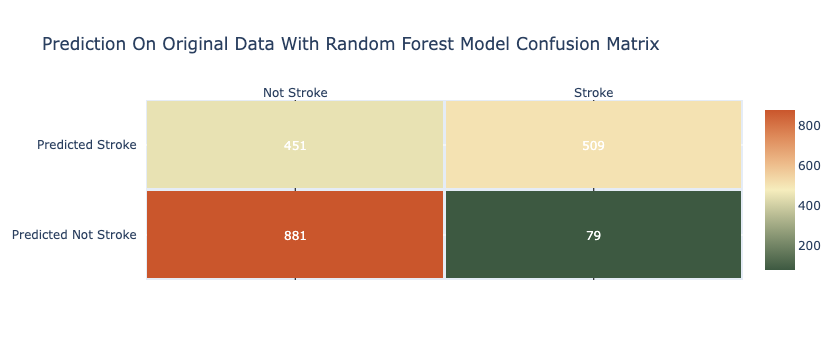

In [24]:
z=RF_CM
fig = ff.create_annotated_heatmap(z, x=['Not Stroke','Stroke'], y=['Predicted Not Stroke','Predicted Stroke'], colorscale='Fall',xgap=3,ygap=3)
fig['data'][0]['showscale'] = True
fig.update_layout(title='Prediction On Original Data With Random Forest Model Confusion Matrix')
fig.show()

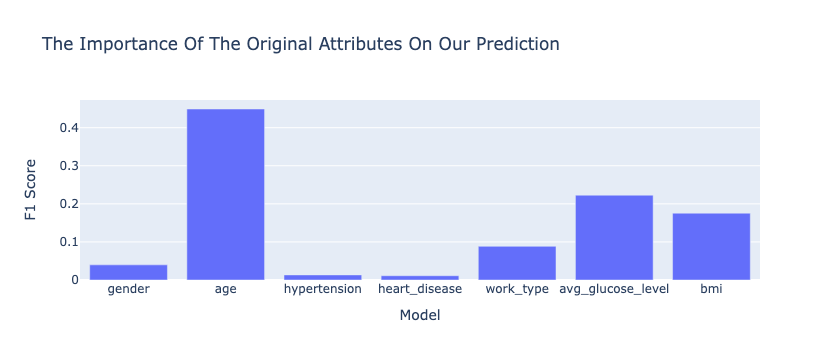

In [25]:
fig = go.Figure()
fig.add_trace(go.Bar(x=X.columns,y=RF_PIPE['DT'].feature_importances_))
fig.update_layout(title='The Importance Of The Original Attributes On Our Prediction',xaxis_title='Model',yaxis_title='F1 Score')
fig.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>A very interesting inference to be made here is what attributes had the most important in predicting stroke-prone individuals and we see that the BMI, age and glucose level of the individuals are by far the most significant predictors for a stroke-prone individual.</span></p>

In [26]:
import pymc3 as pm

stroke_population = s_data.query('stroke==1')
regular_population = s_data.query('stroke==0')

with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    delta = pm.Deterministic("delta", p_A - p_B)

    
    obs_A = pm.Bernoulli("obs_A", p_A, observed=stroke_population.heart_disease)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=regular_population.heart_disease)

    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>Next, we will try to construct a belief that there is a difference between the two groups in our dataset, i.e., the stroke positive and the negative stroke individuals.
We will define two probabilities, $P(A)$ = the probability for heart disease in a  stroke positive individual, and $P(B)$ = the probability a negative stroke individual has heat disease.
Having a more concrete belief that there are differences between the two groups which did not show up on our decision tree model will confirm that there may be more factors that differentiate between the groups but maybe less indicative of a stroke.</span></p>

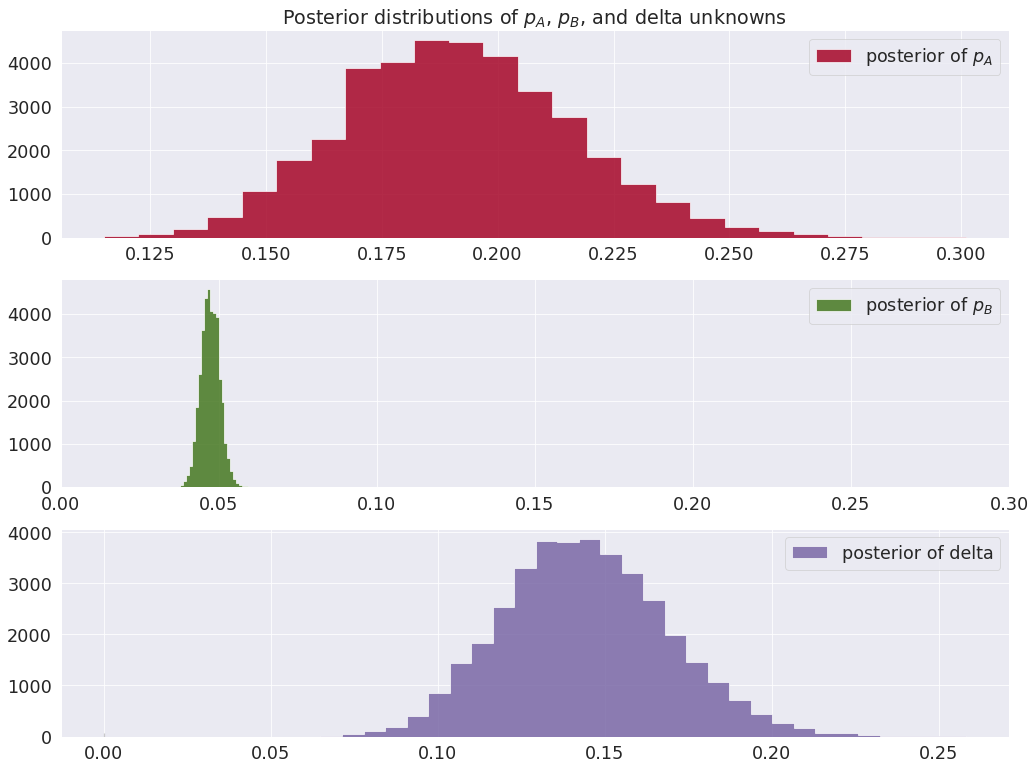

In [27]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]
#histogram of posteriors

plt.xlim(0, .2)
ax = plt.subplot(311)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .3)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6")

plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>After constructing a sampling space of a Bernoulli model and sampling from a uniform distribution of probability values for each group, we examine the results and see that we can say with great confidence that the probability of an individual from the stroke-negative group is much likely to have heart disease wheres the stroke-positive group. However, with less certainty, we can say that the probability for a stroke-positive individual with heart disease is around 0.15-0.21.If it seems less trivial, the delta distribution seen in the third plot is a distribution of the difference between the groups' two probabilities. If there were no difference, we would see a very thin distribution around zero in contrast to what we see that the distribution is far from zero, which indicates there is a definite difference in which we have lower confidence.
</span></p>

<a id="1"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Conclusions</h1>


<ol>
    <li><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>It seems that there two underlying groups based on the joint distribution of BMI and glucose level attributes, in a further analysis it may be of interest to understand what distinguishes those two groups from one another.</span></li>
    <li><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;">We saw that a random forest model trained on an upsampled version of the original dataset yielded satisfiable results as for predicting stroke-prone individuals, further analysis should be conducted to ensure that such results are not due to chance or any bais raising during the modeling stage.</span></span></li>
    <li><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;">We saw that age, BMI, and glucose level are the most important features when it comes to predicting stroke-prone individuals, based on the current dataset.</span></span></li>
    <li><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;">We observed that women are prone to stroke on average at a much older age (74-79) in comparison to males which experiences strokes on average as soon as their mid 50&apos;s and 60, ages which are much rarer for women to have strokes.</span></span></li>
    <li><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;">Surprisingly when looking at the smoking status of our stroke-positive samples we saw that the majority of the samples have never smoked! and the smallest proportion of the store postive samples are smorkes, indeed a peculiar situation, one would think that smoking will increase the probability of an individual to experience a stroke.</span></span></li>
</ol>
<p><br></p>